In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# You will need to adjust BATCH_SIZE based on how much memory your GPU has and how big the resize_input_to values are. 

import os,sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import helper
from torch.utils import data
from datasets import BerkeleyDataSet, BerkeleyDataTestSet

BATCH_SIZE = 3

resize_input_to = [640,360]   
data_root = 'data\\bdd100k';
list_root = os.path.join(data_root, 'lists\\100k\\drivable');

train_dataset = BerkeleyDataSet(data_root, os.path.join(list_root, 'train_images.txt'), resize_to=resize_input_to);
val_dataset = BerkeleyDataSet(data_root, os.path.join(list_root, 'val_images.txt'), resize_to=resize_input_to, train=False);

train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1, pin_memory=True)
val_loader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

test_dataset = BerkeleyDataTestSet(data_root, os.path.join(list_root, 'test_images.txt'), resize_to=resize_input_to);
test_loader = data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1)

#debug_dataset = BerkeleyDataDebugSet(data_root, os.path.join(list_root, 'what_images.txt'), resize_to=resize_input_to);
#debug_loader = data.DataLoader(debug_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

print("Train set: ", len(train_dataset), " Val set: ", len(val_dataset), " Test set: ", len(test_dataset))


Train set:  7000  Val set:  900  Test set:  100


In [3]:
from collections import defaultdict
import torch.nn.functional as F
from loss import dice_loss
from matplotlib import pyplot as plt

def calc_loss(pred, target, metrics, bce_weight=0.5):
    #bce = F.binary_cross_entropy_with_logits(pred, target)
        
    #pred = F.sigmoid(pred)
    #dice = dice_loss(pred, target)
    
    #loss = bce * bce_weight + dice * (1 - bce_weight)
    pred = pred.type(torch.FloatTensor)
    target = target.type(torch.LongTensor)
    loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
    loss = loss_fn(pred, target)
    
    #metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    #metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer, scheduler, epoch, best_loss, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print('-' * 10)
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        
        since = time.time()
        loader = train_loader

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                loader = val_loader;
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for i, batch in enumerate(loader):
                scheduler.batch_step()
                input_images, target_masks, _, _ = batch
                
                inputs = input_images.to(device)
                labels = target_masks.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)
            
            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model with loss: ", epoch_loss)
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [3]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
import torchsummary
import unet_pytorch2
from cyclic_lr import CyclicLR

load_from_checkpoint = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 19
learn_rate = 1e-3

if load_from_checkpoint:
    model = unet_pytorch2.UNet(in_channels=3, n_classes=num_class, depth=5, wf=6, batch_norm=True, padding=True)
    optimizer_ft = optim.Adam(model.parameters(), lr=learn_rate)
    checkpoint = torch.load('model/checkpoint.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    optimizer_ft.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
else:
    model = unet_pytorch2.UNet(in_channels=3, n_classes=num_class, depth=5, wf=6, batch_norm=True, padding=True).to(device)
    optimizer_ft = optim.Adam(model.parameters(), lr=learn_rate)
    epoch = 0
    loss = 1e10

#torchsummary.summary(model, input_size=(3, resize_input_to[1], resize_input_to[0]), device='CUDA')

cuda:0


In [5]:
### TRAIN MODEL 

#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

cyclic_scheduler = CyclicLR(optimizer_ft, step_size=7000)

model = train_model(model, optimizer_ft, cyclic_scheduler, epoch, loss, num_epochs=30)

----------
Epoch 0/29
LR 0.001
train: loss: 2.391321
val: loss: 2.324337
saving best model with loss:  2.324336725870768
46m 7s
----------
Epoch 1/29
LR 0.002880714285714286
train: loss: 2.299224
val: loss: 2.242395
saving best model with loss:  2.2423946324984234
46m 13s
----------
Epoch 2/29
LR 0.004762142857142857
train: loss: 2.248139
val: loss: 2.197311
saving best model with loss:  2.197310972213745
47m 18s
----------
Epoch 3/29
LR 0.005356428571428571
train: loss: 2.217429
val: loss: 2.187773
saving best model with loss:  2.1877730830510456
47m 35s
----------
Epoch 4/29
LR 0.0034750000000000007
train: loss: 2.197337
val: loss: 2.168104
saving best model with loss:  2.168103539943695
48m 13s
----------
Epoch 5/29
LR 0.001593571428571429
train: loss: 2.185995
val: loss: 2.174692
46m 18s
----------
Epoch 6/29
LR 0.0022878571428571427
train: loss: 2.189922
val: loss: 2.173822
46m 26s
----------
Epoch 7/29
LR 0.004169285714285715
train: loss: 2.191346
val: loss: 2.177196
46m 7s
-----

In [6]:
# Checkpoint model to disk

torch.save({
    'epoch' : epoch,
    'model_state_dict' : model.state_dict(),
    'optimizer_state_dict' : optimizer_ft.state_dict(),
    'loss' : loss
}, 'model/checkpoint.pt');


In [4]:
# Evaluation on test set
# This block sets the model to evaluation mode and creates an iterator on the Test dataloader

import math
from matplotlib.colors import Normalize
import matplotlib
from PIL import Image
from sklearn.metrics import jaccard_similarity_score as jsc

NUM_TEST_SAMPLES = 30

mean_ious = np.zeros(NUM_TEST_SAMPLES);
ious_index = 0;

results_folder = os.path.join(data_root, 'seg\\results\\test_color_jan25')
model.eval()   # Set model to evaluate mode
it = iter(test_loader)

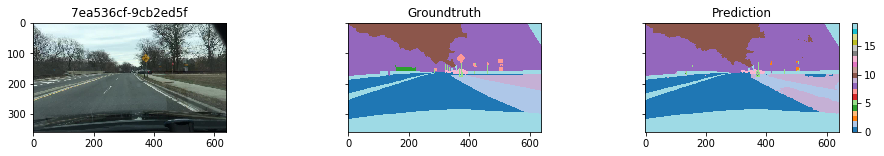

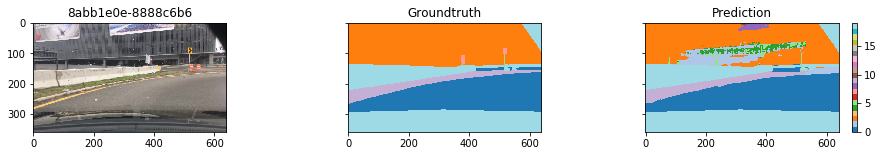

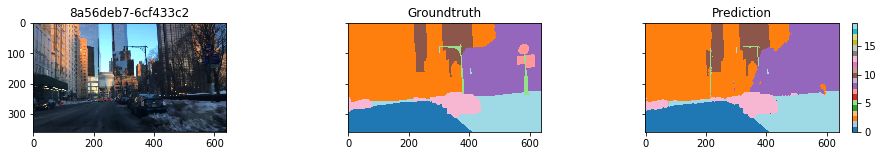

In [14]:
# Each time this block is executed the next BATCH_SIZE test samples are loaded, evaluated and displayed. 
# The Groundtruth and Predicted labels are then written to 'data/bdd100k/seg/results/test' as .png images
# You can execute this block over and over to work your way through the entire test set

inputs, labels, filenames, _ = next(it)
inputs = inputs.to(device)
labels = labels.to(device)

pred = model(inputs)

pred = pred.data.cpu().numpy()
imgs = inputs.data.cpu().numpy()
labels = labels.data.cpu().numpy()

# Map each channel (i.e. class) to each color
target_masks_rgb = [x for x in labels]
pred_rgb = [np.argmax(x, axis=0) for x in pred]
input_images_rgb = [helper.format_network_input_as_image(x) for x in imgs]

cmap = plt.get_cmap('tab20')

for i in range(BATCH_SIZE):
    lbl = pred_rgb[i].reshape(-1)
    target = target_masks_rgb[i].reshape(-1)
    mean_ious[ious_index] = jsc(target,lbl)
    ious_index += 1

    fig, (p1, p2, p3) = plt.subplots(1,3, sharey=True, figsize=(16,2))
    p1.imshow(input_images_rgb[i])
    p1.set_title(filenames[i])
    
    #255 signifies ignored regions, the result here has no bearing on the accuracy so map these regions 
    #to class 19 in both images
    ignore_mask = target_masks_rgb[i] == 255 
    target_masks_rgb[i][ignore_mask] = 19
    pred_rgb[i][ignore_mask] = 19
    p2.imshow(target_masks_rgb[i], cmap=cmap, vmin=0, vmax=19)
    p2.set_title('Groundtruth')
    h = p3.imshow(pred_rgb[i], cmap=cmap, vmin=0, vmax=19)
    p3.set_title('Prediction')
    fig.colorbar(h, ax=p3)
    
    plt.imsave(os.path.join(results_folder, filenames[i]+'_pred.png'), pred_rgb[i], cmap=cmap, vmin=0, vmax=19)
    plt.imsave(os.path.join(results_folder, filenames[i]+'_gt.png'), target_masks_rgb[i], cmap=cmap, vmin=0, vmax=19)

In [15]:
print("Mean IOU each sample: \n", mean_ious)
print("------------")
print("Mean over entire test set: ", np.sum(mean_ious) / NUM_TEST_SAMPLES)

Mean IOU each sample: 
 [0.77768229 0.73233941 0.80604167 0.9121658  0.82391059 0.71210069
 0.83754774 0.6643967  0.47365017 0.70693142 0.80846788 0.76361545
 0.54154948 0.84177951 0.83610243 0.91930122 0.69230035 0.73280382
 0.57564236 0.87229167 0.91371528 0.78695313 0.83955729 0.81253038
 0.89861545 0.71375868 0.70746528 0.71162326 0.58111545 0.8175    ]
------------
Mean over entire test set:  0.7604484953703704


In [ ]:
# Evaluation on test set
# This block sets the model to evaluation mode and creates an iterator on the Test dataloader
from torchnet.meter import APMeter

map_scores = np.zeros(NUM_TEST_SAMPLES);

apmeter = APMeter()

results_folder = os.path.join(data_root, 'seg\\results\\final_jan25')
gt_folder = os.path.join(data_root, 'seg\\results\\final_gt')
model.eval()   # Set model to evaluate mode
it = iter(test_loader)

In [ ]:
# Save the predicted and GT masks for all test samples so they can be evaluated with Berkeley's evaluate.py script

for b in range(100):

    inputs, labels, filenames, _ = next(it)
    inputs = inputs.to(device)
    labels = labels.to(device)

    pred = model(inputs)

    pred = pred.data.cpu().numpy()
    imgs = inputs.data.cpu().numpy()
    labels = labels.data.cpu().numpy()

    # Map each channel (i.e. class) to each color
    target_masks_rgb = labels[0]
    pred_rgb = np.argmax(pred[0], axis=0)
    pred_rgb[target_masks_rgb == 255] = 255
    print(pred_rgb.shape)
    
    cmap = plt.get_cmap('tab20')

    predimg = Image.fromarray(pred_rgb.astype('uint8'))
    predimg.save(os.path.join(results_folder, filenames[0]+'.png'))
    
    gtimg = Image.fromarray(target_masks_rgb.astype('uint8'))
    gtimg.save(os.path.join(gt_folder, filenames[0]+'.png'))